In [5]:
%%capture
!apt install python3-dev graphviz libgraphviz-dev pkg-config
!pip install networkx pygraphviz matplotlib

In [31]:
import numpy as np
import pandas as pd
import networkx as nx

from networkx.drawing.nx_agraph import graphviz_layout
from typing import List
from typing import Tuple
from random import random

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

from copy import deepcopy

In [7]:
# Get machine epsilon.
e = np.finfo(np.float64).eps

# Learning Bayesian Networks from Big Data with Greedy Search

## Introduction

One of the main important task in the causal framework is the **causal discovery task**. The aim of which is to find the **causal model** underline some given observational data. 




In particular, using the tool of **causal network**, the discovery task became the task of identifying:
1. a Directed Acyclic Graph (DAG) and 
2. a set of conditional probability distribution.

These two subtasks are referred as:
1. structure learning
2. parameter learning

In order to *justify* the use of **causal network** we have to assume that the underlying causal process follows a **probability distribution** $P$. So that, the underlying process can be represented by means of **observational data** sampled from the distribution $P$.

In this notebook the focus will be on the activity of **structure learning**. Essentially, a partial implementation of the "**Algorithm 1** Greedy Search" described in the paper [1] will be provided.


### Algorithm 1: Greedy Search

This algorithm belong to the class of the so called **score-based** algorithm. Which means that it follows a certain **methodology to explore** the space of possible DAG using a provided **score function** to evaluate candidate DAGs. 

In the following, the portion of the Algorithm 1 that will be implemented in this notebook is described.

---

**Alghorithm 1** Greedy Search 

---

**Input**: a data set $D$ from $X$, an initial DAG $G$ (usually the empty DAG),
a score function $Score(G,D)$.

**Output**: the DAG $G_{max}$ that maximises $Score(G,D)$.
1. Compute the score of $G$, $S_G = Score(G,D)$.
2. Set $S_{max} = S_G$ and $G_{max} = G$.
3. **Hill climbing**: repeat as long as $S_{max}$ increases:
  1. for every possible arc addition, deletion or reversal in $G_{max}$ resulting in a DAG:
    1. compute the score of the modified DAG $G^∗$, $S_{G^∗} = Score(G^∗,D)$:
    2. if $S_{G^∗} > S_{max}$ and $S_{G^∗} > S_G$, set $G = G^∗$ and $S_G = S_{G^∗}$ .
  2. if $S_G > S_{max}$, set $S_{max} = S_G$ and $G_{max} = G$.
---

#### Input

The inputs needed by the algorithm are:
1. an initial DAG $G$, that is the DAG from which the search will start
2. a dataset $D$ and a score function $Score(G,D)$; these two elements are necessary to evaluate a DAG. Indeed, the score function provides a mathematical expression that can be used to compare a candidate DAG $G$ with collected data $D$. If the DAG has an high score, it is likely to **correctly represent** the structure of the causal model that has generated the data.

The score function used in this notebook is the log-likelihood ($LL$) and it will be described in a specific section.

#### Step 1 / 2

The first and second steps are simply initialization steps, and they consists in:
1. evaluate the initial DAG $G$ 
2. initialize the value of the variables $S_{max}$ and $G_{max}$. At the end of the procedure these quantity will correspond to the optimal DAG and its value with respect to the chosen score function

#### Step 3

A brief description of **hill climbing**. The **hill climbing** is an optimization technique that follows an iteratively procedure. The method produces at each iteration a set of candidate solution modifying the previous one in some way. Then it updates the current solution only if at least one of the new candidates has a better score than the actual solution, otherwise it stops.

The **hill climnbing** tecnhique belongs to the so called **local search** methods. Indeed, at each iteration, it explores new possible solutions obtained using a local move starting from the actual one. 


Furthermore, because it updates the current solutions only if a new, better solution is found, this method is only able to reach certainly the global maximum in **convex optimization** problems. Otherwise, it could get stacked in a **local maxima or minima**.

In **Algorithm 1** local moves correspond to:
- addition
- deletion
- reversal

the step:
- 1.1. compute a new candidate DAG applying one of the previous moves
- 1.2. verify if the new DAG is better that the best DAG obtained up to this moment and update the variables if necessary 


#### Output

The DAG which maximize the score function, that is a local optimal solution or the global optimal one. 

### Log-Likelihood (LL)

The score function used in the implementation of **Algorithm 1** is the log-likelihood (LL), which is defined as follows:

$$LL(\mathcal{G}|D)=\sum_{i=1}^n\sum_{j=1}^{q_i}\sum_{k=1}^{r_i}N_{ijk}\cdot \log \left( \frac{N_{ijk}}{N_{ij*}} \right)$$

where:
- $n$ is the number of vertices in $\mathcal{G}$, or the number of variables in $D$,
- $q_i$ is the number of possible configurations of $Pa(X_i)$,
- $r_i$ is the number of possible levels of $X_i$,
- $N_{ijk}$ is the absolute frequency of observing $X_i$ with the $j$-th configuration and the $k$-th level,
- and finally $N_{ij*} = \sum_{k=1}^{ri} N_{ijk}$.

We can derive the previous formula recalling that the given dataset $D$ on which applied the **Algorithm 1** is *discrete* and assuming that both $X$ and the $X_i$ are *multinomial* random variables.

Then, given a DAG $\mathcal{G}$ and assuming the probability of underlying process $P$ factorizes according to $\mathcal{G}$, we can write:

$$ P(X|G) =  ∏_{i=1}^n P(X_i|Pa(X_i)) $$

If the distribution of $X$ dependes on parameter $Θ$, we have:

$$ P(X|G,\Theta) =  ∏_{i=1}^n P(X_i|Pa(X_i), Θ_{X_i}) $$

where:

$$\bigcup_{i=1}^n \Theta_{X_i}=Θ$$

Assuming that both $X=(X_1,\dots,X_n)$ and $X_i$ are multinomial random variables. Local distributions take the form:

$$X_i|Pa(X_i) ∼ Mul(\pi_{ik|j}), \qquad \pi_{ik | j} = P(X_i = k |Pa(X_i)= j );$$

Obtaining the likelihood function:

$$ L(\mathcal{G}|x) = ∏_{i=1}^n ∏_{j=1}^{q_i} ∏_{k=1}^{r_i} \pi_{ik|j}^{x_{ijk}}$$

Applying the $\log$:

$$LL(\mathcal{G}|x) = \log(∏_{i=1}^n ∏_{j=1}^{q_i} ∏_{k=1}^{r_i} \pi_{ik|j}^{x_{ijk}}) = \sum_{i=1}^n \sum_{j=1}^{q_i} \sum_{k=1}^{r_i} \log(\pi_{ik|j}^{x_{ijk}})=\sum_{i=1}^n \sum_{j=1}^{q_i} \sum_{k=1}^{r_i} x_{ijk}\cdot\log(\pi_{ik|j})$$

Given a dataset $D$ obtained sampling from the distribution of $X$, we can substitute $x_{ijk}$ and $\pi_{ik|j}$ with $N_{ijk}$ and $\frac{N_{ijk}}{N_{ij*}}$ respectively.

So the $LL$ score function measure the likelihood of obtaining observed data $D$ if the true structure of the cuasal model is the one represented by the DAG $\mathcal{G}$.

## Implementation

### Read Data and Graph

In [8]:
# Read data from file.
D = pd.read_csv("./final_project_data.csv", dtype = "category")
# Build the true graph.
G = nx.DiGraph([
    ("A", "T"),
    ("S", "L"),
    ("S", "B"),
    ("B", "D"),
    ("E", "D"),
    ("T", "E"),
    ("L", "E"),
    ("E", "X")
])

In [9]:
D.head()

,A,S,T,L,B,E,X,D
0,no,yes,no,no,yes,no,no,yes
1,no,yes,no,no,no,no,no,no
2,no,no,yes,no,no,yes,yes,yes
3,no,no,no,no,yes,no,no,yes
4,no,no,no,no,no,no,no,yes


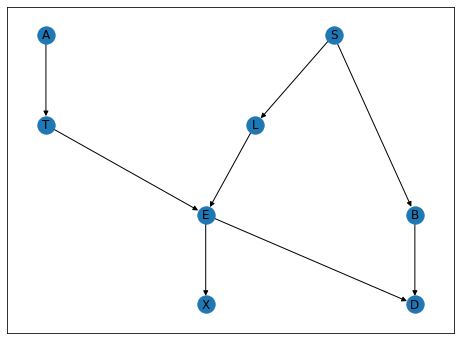

In [10]:
nx.draw_networkx(G, pos = graphviz_layout(G, prog = "dot"), with_labels = True)

### Computing the Absolute Frequencies

In [11]:
# Compute the absolute frequencies N(X, Pa(X) | D).
def N(X: str, Z: List[str], D: pd.DataFrame) -> np.ndarray:
    # 1. Add a fake column to D, (this is needed if a 
    # node is child of every other node)
    D_ =  deepcopy(D)
    D_['fake'] = np.zeros((len(D),1))

    # 1. Group data with respect to provided variables
    abs_freq = D_.groupby([X]+Z)
    
    # 2. Count the number of observation in each group
    abs_freq = abs_freq.count()['fake']

    # 3. Cast the resulting Series in an numpy array
    abs_freq = abs_freq.to_numpy(dtype=np.ndarray)

    # 4. Re-shaping the array to match the dimension required
    if len(Z) == 0:
      t = (D[X].unique().size,1)
    else:
      t = (D[X].unique().size, int(len(abs_freq)/D[X].unique().size))
    
    abs_freq = abs_freq.reshape(t).T

    return abs_freq

In [12]:
# Compute N(A | D).
np.testing.assert_equal(
    N("A", [], D),
    np.array([[4958,   42]])
)

In [13]:
# Compute N(A, [L] | D).
np.testing.assert_equal(
    N("A", ["L"], D),
    np.array([
        [4632,   38],
        [ 326,    4]
    ])
)

In [14]:
# Compute N(A, [L, T] | D).
np.testing.assert_equal(
    N("A", ["L", "T"], D),
    np.array([
        [4594,   36],
        [  38,    2],
        [ 322,    4],
        [   4,    0]
    ])
)

### Computing the Log-Likelihood

In [16]:
# Compute log-likelihood of LL(X, Pa(X) | D).
def ll(X: str, Z: List[str], D: pd.DataFrame) -> float:
    # 1. Compute the absolute frequencies
    N_ijk = N(X, Z, D)

    # 2. Compute the sum of abs. freq. over possible levels of X
    N_ijstar = N_ijk.sum(axis=1).reshape((N_ijk.shape[0],1))

    # 2.1 Find 0 value (menaning that a particular possible
    # configuration of parents is not represented in the data)
    zero_index = np.where(N_ijstar == 0)[0]

    #2.2 Delete such row to avoid division by 0
    N_ijk = np.delete(N_ijk, zero_index, axis = 0)
    N_ijstar = np.delete(N_ijstar, zero_index, axis = 0)

    # 3. Compute the relative frequencies 
    rel_freq = (N_ijk/N_ijstar).astype('float')

    # 4. Substitute 0 values with 1 (in order to avoid 
    #    inf value when apply the logarithm)
    rel_freq[rel_freq==0] = 1

    # 5. Apply the log to relative frequencies
    log_rel_freq = np.log(rel_freq)

    # 6. Weight the log relative frequencies
    weighted_log_rel_freq = (N_ijk * log_rel_freq)

    # 7. Compute the log-likelihood 
    ll = weighted_log_rel_freq.sum()

    return ll

In [17]:
# Compute LL(A | D).
np.testing.assert_approx_equal(
    ll("A", [], D),
    -242.5631
)

In [18]:
# Compute LL(A, [L] | D).
np.testing.assert_approx_equal(
    ll("A", ["L"], D),
    -242.3023
)

In [19]:
# Compute LL(A, [L, T] | D).
np.testing.assert_approx_equal(
    ll("A", ["L", "T"], D),
    -240.2226
)

In [20]:
# Compute log-likelihood of LL(G | D).
def LL(G: nx.DiGraph, D: pd.DataFrame) -> float:
    nodes = G.nodes
    ll_ = [ll(X, list(G.predecessors(X)), D) for X in G.nodes]
    LL = sum(ll_)
    return LL

In [21]:
# Compute LL(G | D).
np.testing.assert_approx_equal(
    LL(G, D),
    -11033.0871
)

### Implementing Hill-Climbing

In [23]:
def outEdge(G: nx.DiGraph, D: pd.DataFrame):
  l = []

  for c1 in D.columns:
    for c2 in D.columns:
      if c1 != c2 and (c1,c2) not in G.edges:
        l.append((c1,c2))

  return l

In [41]:
# Hill-Climbing.
def HC(D: pd.DataFrame, initG: nx.DiGraph = None, score_func = LL, max_iter: int = 100, verbose: bool = True) -> Tuple[nx.DiGraph, list]:

  # Step 1 - initialization
  if initG is None:
    G = nx.DiGraph()
    G.add_nodes_from(D.columns)
    SG = score_func(G,D)
  else:
    G = initG
    SG = score_func(G,D)

  # Step 2 - initialization
  Gmax = G.copy()
  Smax = SG

  # Step 3 - Hill Climbing
  stayInLoop = True
  i=0
  move = ''
  scoreHistory = []

  while stayInLoop:
    if verbose: print('----------------------',i,'------------------------')
    Gstar = G.copy()
    SGstar = SG

    arcInGraph = deepcopy(Gstar.edges())
    arcNotInGraph = outEdge(Gstar, D)

    # explore addition moves
    for arc in arcNotInGraph:
      Gstar.add_edges_from([arc])

      if nx.is_directed_acyclic_graph(Gstar):
        SGstar = score_func(Gstar, D)
        
        if SGstar > SG:
          move='addition'+str(arc)
          G = deepcopy(Gstar)
          SG = SGstar
        
      Gstar.remove_edges_from([arc]) 

    #explore removal moves
    for arc in arcInGraph:
      Gstar.remove_edges_from([arc])

      if nx.is_directed_acyclic_graph(Gstar):
        SGstar = score_func(Gstar, D)
        
        if SGstar > SG:
          move='removal'+str(arc)
          G = deepcopy(Gstar)
          SG = SGstar
      
      Gstar.add_edges_from([arc]) 

    # explore reversal moves
    for arc in arcInGraph:
      Gstar.remove_edges_from([arc])
      Gstar.add_edges_from([(arc[1],arc[0])])

      if nx.is_directed_acyclic_graph(Gstar):
        SGstar = score_func(Gstar, D)
        if SGstar > SG:
          move='reversal'+str(arc)
          G = deepcopy(Gstar)
          SG = SGstar

      Gstar.remove_edges_from([(arc[1],arc[0])])
      Gstar.add_edges_from([arc])  

    # verify stop criterion
    if SG > Smax and i < max_iter:
      if verbose: print(move, SG, '\n') 
      i+=1
      Gmax = deepcopy(G)
      Smax = SG
      scoreHistory.append(Smax)
    else:
      if verbose: print('exit', SG)
      stayInLoop = False
  
  return(Gmax,scoreHistory)

In [42]:
H, scoreHistory = HC(D)

---------------------- 0 ------------------------
addition('B', 'D') -14002.24978648194 

---------------------- 1 ------------------------
addition('L', 'E') -12913.154780918298 

---------------------- 2 ------------------------
addition('E', 'X') -11980.76535150478 

---------------------- 3 ------------------------
addition('B', 'S') -11529.436949515439 

---------------------- 4 ------------------------
addition('T', 'E') -11299.207351065748 

---------------------- 5 ------------------------
addition('E', 'D') -11159.852930289939 

---------------------- 6 ------------------------
addition('S', 'L') -11034.897167266437 

---------------------- 7 ------------------------
addition('L', 'D') -11031.782158214999 

---------------------- 8 ------------------------
addition('A', 'D') -11028.573898957238 

---------------------- 9 ------------------------
addition('T', 'S') -11025.9108402543 

---------------------- 10 ------------------------
addition('B', 'L') -11023.713088172735 

--

In [43]:
scoreHistory[-1]

-11004.336691505503

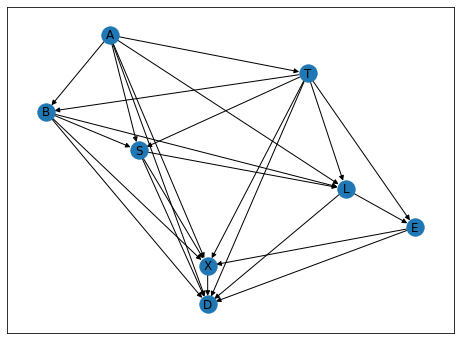

In [27]:
nx.draw_networkx(H, pos = graphviz_layout(H, prog = "dot"), with_labels = True)

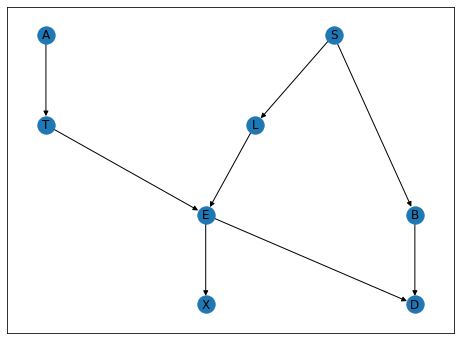

In [28]:
G = nx.DiGraph([("A", "T"), ("S", "L"), ("S", "B"), ("B", "D"), ("E", "D"), ("T", "E"), ("L", "E"), ("E", "X")])
nx.draw_networkx(G, pos = graphviz_layout(G, prog = "dot"), with_labels = True)

### Testing Hill-Climbing

In [29]:
def graphTest(candidateG: nx.DiGraph, trueG: nx.DiGraph) -> pd.DataFrame:
  cols = ['total_edges', 'same_edges', 'missing_edges', 'extra_edges', 'reversed_edges']

  total = len(candidateG.edges)
  same = len(nx.intersection(candidateG, trueG).edges)
  reversed = len(nx.intersection(nx.reverse(candidateG), trueG).edges)
  extra = len(nx.difference(candidateG, trueG).edges) - reversed
  missing = len(nx.difference(trueG, candidateG).edges) - reversed

  result = pd.DataFrame([[total, same, missing, extra, reversed]], columns=cols)
  return result

In [30]:
graphTest(H, G)

,total_edges,same_edges,missing_edges,extra_edges,reversed_edges
0,24,7,0,16,1


In [56]:
seed = 1
mapping = {0:'A', 1:'T', 2:'S', 3:'L', 4:'B', 5:'D', 6:'E', 7:'X'}
temp = [] 

for i in range(20):
  initG = nx.gn_graph(8, kernel=None, create_using=None, seed=i)
  nx.relabel_nodes(initG, mapping, False)

  if nx.is_directed_acyclic_graph(initG):
    F, _ = HC(D, initG, verbose=False)
    temp2 = graphTest(F, G)
    temp.append(temp2)

results = pd.concat(temp, ignore_index=True)

In [57]:
results

,total_edges,same_edges,missing_edges,extra_edges,reversed_edges
0,27,4,0,19,4
1,24,4,1,17,3
2,26,4,0,18,4
3,27,4,0,19,4
4,25,7,0,17,1
5,26,1,0,18,7
6,28,4,0,20,4
7,26,6,0,18,2
8,26,4,0,18,4
9,24,4,1,17,3


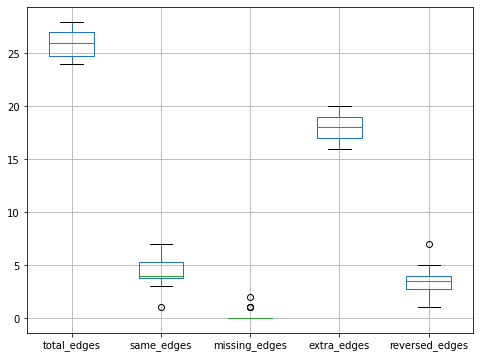

In [58]:
results.boxplot()

We can observe that the HC algorithm lead always to graphs with a very large number of edges w.r.t. the true graph G. Extra edges are greater than 15 in every run with a different initial graph. 

This, togheter with the knowledge that real graphs tend to have few connections, suggest the necessity to control for the growth of the graph.

We observe also that the empty graph as initialization gives the best result.

## Reference

[1] [Marco Scutari, Claudia Vitolo, Allan Tucker. *Learning Bayesian networks from big data with greedy search:
computational complexity and efficient implementation*, Statistics and Computing (2019) 29:1095–1108, *https://doi.org/10.1007/s11222-019-09857-1*]